### Here we will try to understand about the different parameter of LLM that decides the level of determinism and creativity of the model while giving answers.These parameters are:
* Temperature
* Top p
* Top k

In [82]:
# generate a sample of logit values for arbitrary number of classes
def get_logits():
    import numpy as np
    import random
    logit_samples=20
    logit_values=np.array(random.sample(range(0,20),logit_samples))
    return logit_values

#### Temperature
It is used to scale the logits before doing top_p or top k filtering followed by softmax.If temperature is less than <1 then it scales up the logits making the distrubution a very centered towards to max logit,while if it is greater then 1 then it scales down the logits.making the prob distribution distributed towards other logits also.

In [89]:

# apply softmax to the logit values
import numpy as np
def softmax(x,temperature=1):
    x=np.array(x)
    if temperature==0:
        # if temperature is zero, softmax is equivalent to argmax
        # make the highest logit value 1 and the rest 0
        return np.where(x==np.max(x),1,0)
    return np.exp(x/temperature) / np.sum(np.exp(x/temperature), axis=0)


In [90]:
# let collection softmax values at different temperatures
temperatures=[0,0.3,0.5,1,2]
logit_values=get_logits()

softmax_values_collection=[]
for temperature in temperatures:
    softmax_values_collection.append(softmax(logit_values,temperature))


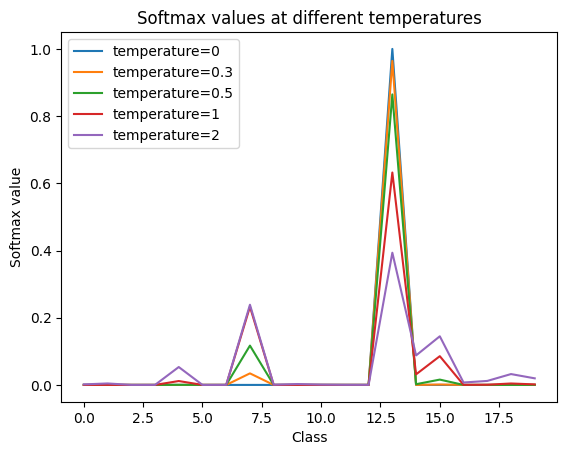

In [94]:
# plot the softmax value on a line curve for each temperature
import matplotlib.pyplot as plt
plt.figure()
for i,temperature in enumerate(temperatures):
    plt.plot(softmax_values_collection[i],label='temperature='+str(temperature))

plt.legend()
plt.title('Softmax values at different temperatures')
plt.xlabel('Class')
plt.ylabel('Softmax value')
plt.show()

#### Top k
It is used to filter the exact number of logits before applying the softmax.With a given k value,k largest logits are filtered out.This step is applied after rescaling the logits using temperature.

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.24472847 0.66524096
 0.         0.         0.         0.         0.09003057 0.
 0.         0.        ]
[0.         0.         0.         0.         0.03168492 0.
 0.         0.         0.         0.         0.23412166 0.63640865
 0.01165623 0.         0.         0.         0.08612854 0.
 0.         0.        ]


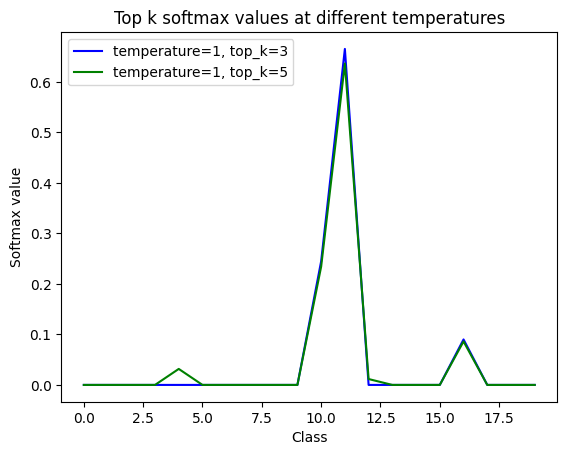

In [109]:
temperature_values=[1]
top_k_values=[3,5]

def rescale_logits_by_temperature(logits,temperature):
    return logits/temperature

def get_topk_logits(logits,top_k):
    # get top k logits
    top_k_logits_indxs=np.argpartition(logits, -top_k)[-top_k:] #an optimized way to get top k indices
    top_k_logits=logits[top_k_logits_indxs]
    return top_k_logits,top_k_logits_indxs
    

def softmax_topk_softmax(logit_values,temperature,top_k):
    # rescale logits by temperature
    logit_values=rescale_logits_by_temperature(logit_values,temperature)
    # get top k logits
    top_k_logits,top_k_logits_indxs=get_topk_logits(logit_values,top_k)
    # apply softmax to top k logits
    top_k_softmax_values=softmax(top_k_logits)
    new_softmax_values=np.zeros_like(logit_values)
    new_softmax_values[top_k_logits_indxs]=top_k_softmax_values
    return new_softmax_values

# plot the softmax value on a line curve for each temperature
# for different temperature use different line types
# for different top k values use different colors
# Define line styles and colors
line_styles = ['solid', 'dashed','dotted']
colors = ['b', 'g', 'r']

plt.figure()

logits=get_logits()
for i, temperature in enumerate(temperature_values):
    for j, top_k in enumerate(top_k_values):
        softmax_values = softmax_topk_softmax(logits.copy(), temperature, top_k)
        print(softmax_values)
        line_style = line_styles[i]
        color = colors[j]
        plt.plot(softmax_values, label=f'temperature={temperature}, top_k={top_k}', linestyle=line_style,color=color)

plt.legend()
plt.title('Top k softmax values at different temperatures')
plt.xlabel('Class')
plt.ylabel('Softmax value')
plt.show()


#### Top P(nucleaus sampling)
Top p is used to filter the logits according to cumulative probability of the logits.It returns the logits whose cumulative probability is less than or equal to give top p value.This is usually applied after temperature scaling and top k filtering.

[1.56687021e-03 1.93367146e-07 4.25919483e-03 6.32120560e-01
 1.15776919e-02 8.55482150e-02 7.80098745e-05 2.61693975e-08
 3.14714295e-02 1.05574885e-05 2.12052824e-04 9.62718333e-09
 2.32544158e-01 1.42880069e-06 2.86982290e-05 3.54164282e-09
 5.25626400e-07 7.11357977e-08 3.88388295e-06 5.76419339e-04]
[1.56687021e-03 1.93367146e-07 4.25919483e-03 6.32120560e-01
 1.15776919e-02 8.55482150e-02 7.80098745e-05 2.61693975e-08
 3.14714295e-02 1.05574885e-05 2.12052824e-04 9.62718333e-09
 2.32544158e-01 1.42880069e-06 2.86982290e-05 3.54164282e-09
 5.25626400e-07 7.11357977e-08 3.88388295e-06 5.76419339e-04]
[1.56687021e-03 1.93367146e-07 4.25919483e-03 6.32120560e-01
 1.15776919e-02 8.55482150e-02 7.80098745e-05 2.61693975e-08
 3.14714295e-02 1.05574885e-05 2.12052824e-04 9.62718333e-09
 2.32544158e-01 1.42880069e-06 2.86982290e-05 3.54164282e-09
 5.25626400e-07 7.11357977e-08 3.88388295e-06 5.76419339e-04]
[1.56687021e-03 1.93367146e-07 4.25919483e-03 6.32120560e-01
 1.15776919e-02 8.554

<Figure size 1200x800 with 0 Axes>

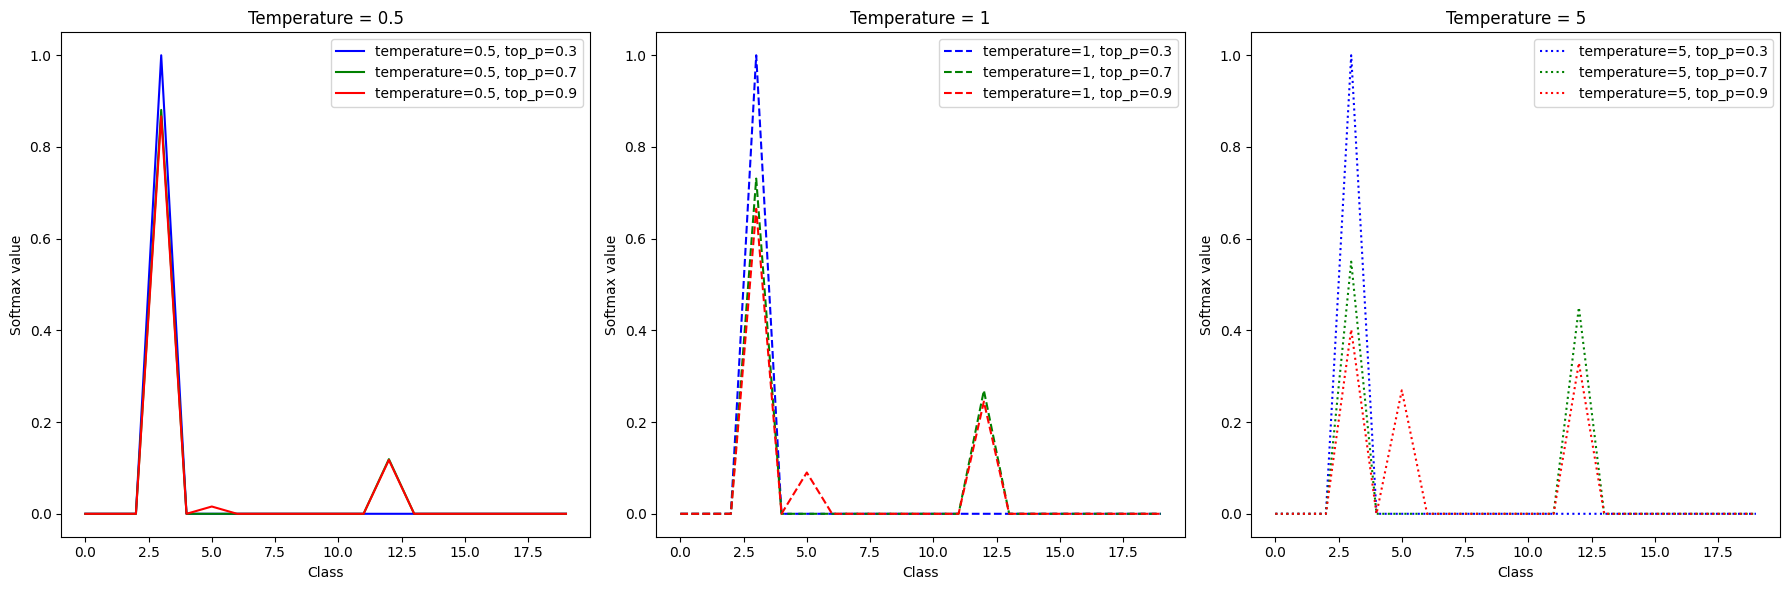

In [118]:

def get_top_p_logits(logits,softmax_values,top_p):
    # get the logits whoose sum of softmax values is less than or equal to top_p
    sorted_softmax=np.argsort(softmax_values)[::-1]
    top_p_logits=[]
    top_p_logits_indxs=[]
    sum_softmax=0
    for i in sorted_softmax:
        sum_softmax+=softmax_values[i]
        top_p_logits.append(logits[i])
        top_p_logits_indxs.append(i)
        if sum_softmax>=top_p:
            break
    return np.array(top_p_logits),np.array(top_p_logits_indxs)

def softmax_top_p_softmax(logit_values,temperature,top_p):
    # apply softmax with temp to logits
    rescaled_logits=rescale_logits_by_temperature(logit_values,temperature)
    softmax_values=softmax(logits)
    print(softmax_values)
    # get top p logits
    top_p_logits,top_p_logits_indxs=get_top_p_logits(rescaled_logits,softmax_values,top_p)
    # apply softmax to top p logits
    top_p_softmax_values=softmax(top_p_logits)
    new_softmax_values=np.zeros_like(softmax_values)
    new_softmax_values[top_p_logits_indxs]=top_p_softmax_values
    return new_softmax_values

# plot the softmax value on a line curve for each temperature
# for different temperature use different line types
# for different top p values use different colors
# Define line styles and colors

line_styles = ['solid', 'dashed','dotted']
colors = ['b', 'g', 'r']
top_p_values=[0.3,0.7,0.9]
temperature_values=[0.5,1,5]
plt.figure(figsize=(12, 8))

logits = get_logits()
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, temperature in enumerate(temperature_values):
    for j, top_p in enumerate(top_p_values):
        softmax_values = softmax_top_p_softmax(logits, temperature, top_p)
        line_style = line_styles[i]
        color = colors[j]
        axs[i].plot(softmax_values, label=f'temperature={temperature}, top_p={top_p}', linestyle=line_style, color=color)
    # set legend, title, x and y labels
    axs[i].legend()
    axs[i].set_title(f'Temperature = {temperature}')
    axs[i].set_xlabel('Class')
    axs[i].set_ylabel('Softmax value')

plt.tight_layout()
plt.show()

### Questions:
1. What's the difference between top p and top k filtering.Basically why do we need two filters?

It is because top k is a deterministic filteration.Through top k we can determine the number of logits that we want to proceed with.While top p is a filteration which depends upon the probabilitis distribution of logits.For example if your number of final logits is very large,then we can firstly use top k to filter out the logits we want to process and then top p to filter out the most probable logits.These two filters can be used together or separately also.

2. What are the steps that are followed to get the final token?

**Ans:**

1. Apply temperature scaling.
2. Filter the \( k \) largest logits.
3. Apply softmax on those logits.
4. Filter the logits whose cumulative probability is less than the top-p value.
5. Apply softmax again on the final filtered logits.
6. Do sampling to get the final token (sampling is done by considering the final probabilities).
